In [27]:
import torch 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import string
import heapq
import matplotlib.pyplot as plt
from operator import itemgetter
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import sklearn.svm as svm
from sklearn.decomposition import PCA
import re
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import classification_report

## Preprocessing

In [77]:
df = pd.read_csv("final2.csv")

In [78]:
sw = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "in", "out", "on", "off", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

In [79]:
df.head()

,tweets_dict,label
0,Blue Ridge Bank shares halted by NYSE after #b...,1
1,"😎 Today, that's this #Thursday, we will do a ""...",1
2,"Guys evening, I have read this article about B...",1
3,💹 Trade #Crypto on #Binance \n\n📌 Enjoy #Cashb...,1
4,🔄 Prices update in $EUR (1 hour):\n\n$BTC - ...,1


Getting Rid of the emojis

In [80]:
def deEmojify(text):
    emoj = re.compile("["
        #u"\U0001F600-\U0001F64F"  # emoticons
        #u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', text)

Getting rid of stopwords urls, punctuation, etc.

In [82]:
counts = {}
for i in range(len(df)): 
    text = deEmojify(df.iloc[i]["tweets_dict"]).translate(str.maketrans('', '', string.punctuation))
    tokenized_tweet = [word.lower() for word in text.split() if (word not in sw and word[0:4] != "http" and word[-1:] != "…")]
    for tok in tokenized_tweet:
        if tok not in counts.keys():
            counts[tok] = 1
        else: 
            counts[tok] += 1

In [83]:
len(counts)

136200

## One-hot Encoding

In [84]:
num_features = int(len(counts)/2)
topitems = heapq.nlargest(num_features, counts.items(), key=itemgetter(1))

In [85]:
features = {}
i = 0
for item in topitems: 
    features[item[0]] = i
    i += 1

In [95]:
labels = df["label"].values

In [88]:
phi = np.zeros((len(df), len(features)))

for i in range(len(df)): 
    text = deEmojify(df.iloc[i]["tweets_dict"]).translate(str.maketrans('', '', string.punctuation))
    tokenized_tweet = [word.lower() for word in text.split(" ") if (word not in sw and word[0:4] != "http" and word[-1:] != "…")]
    for tok in tokenized_tweet:
        if tok in features.keys():
            phi[i][features[tok]] += 1

## Naive Bayes Model

In [89]:
X_train, X_test, y_train, y_test = train_test_split(phi, labels, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [ ]:
alphas = [0.0001,0.001,0.01, 0.1, 1, 10]
train_acc=[]
val_acc=[]
for alpha in alphas: 
    clf = ComplementNB(alpha = alpha)
    clf.fit(X_train, y_train)
    train_acc.append(clf.score(X_train, y_train))
    val_acc.append(clf.score(X_val, y_val))

In [28]:
train_acc

[0.8169130922754111,
 0.812765334504465,
 0.8018347728492656,
 0.7707997852925389,
 0.7049236324598643,
 0.6203581710828088]

In [30]:
val_acc

[0.5895784543325527,
 0.5920667447306791,
 0.5949941451990632,
 0.59557962529274,
 0.5881147540983607,
 0.5563524590163934]

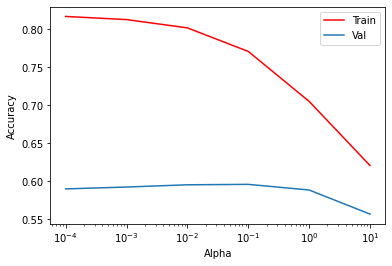

In [35]:
plt.plot(alphas, train_acc, 'r', label = "Train") # plotting t, a separately 
plt.plot(alphas, val_acc, label = "Val") 
plt.xscale('log')
plt.legend()
plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.savefig("nb.jpg")

In [94]:
clf = ComplementNB(alpha = 0.1)
clf.fit(X_train, y_train)
test_acc = clf.score(X_test, y_test)

In [ ]:
print(classification_report(y_test, y_pred, digits=3))

In [91]:
train_acc = clf.score(X_train, y_train)

In [92]:
test_acc

0.4178864168618267

In [93]:
train_acc

0.6819889718440443

## PCA

In [ ]:
pca = PCA(n_components=len(phi/2))
phi_reduced = pca.fit_transform(phi)
X_train, X_test, y_train, y_test = train_test_split(phi_reduced, labels, test_size=0.2, random_state=45)
clf = LinearSVC(random_state=0, tol=1e-5)
clf.fit(X_train, y_train)
train_acc.append(clf.score(X_train, y_train))
test_acc.append(clf.score(X_test, y_test))


In [ ]:
plt.savefig("3var_train.jpg")

<Figure size 432x288 with 0 Axes>

In [ ]:
pca = PCA(n_components=700)
phi_reduced = pca.fit_transform(phi)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(phi_reduced, labels, test_size=0.2, random_state=45)

## Support Vector Machine

In [ ]:
Cval = [0.0001, 0.001, 0.01, 0.05, 0.1, 1, 10]
train_acc_svm=[]
val_acc_svm=[]

for c in Cval:  
    print(c)
    clf = LinearSVC(random_state=0, C=c, tol=1e-3, max_iter=10000)
    clf.fit(X_train, y_train)
    train_acc_svm.append(clf.score(X_train, y_train))
    val_acc_svm.append(clf.score(X_val, y_val))


In [47]:
train_acc_svm = train_acc[-7:]
val_acc_svm = val_acc[-7:]

In [52]:
train_acc_svm

[0.6098179866295809,
 0.6695944956814522,
 0.7897818767383985,
 0.8851803054701606,
 0.9167032645293515,
 0.9668667349826771,
 0.9815546772068511]

In [53]:
val_acc_svm

[0.6030444964871194,
 0.6232435597189696,
 0.6292447306791569,
 0.6213407494145199,
 0.6179742388758782,
 0.6086065573770492,
 0.5844555035128806]

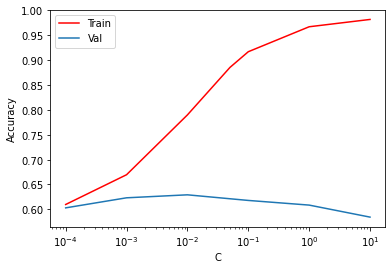

In [55]:
plt.plot(Cval, train_acc_svm, 'r', label = "Train") # plotting t, a separately 
plt.plot(Cval, val_acc_svm, label = "Val") 
plt.xscale('log')
plt.legend()
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.savefig("svm.jpg")

In [97]:
clf = LinearSVC(random_state=0, C=0.01, tol=1e-3, max_iter=10000)
clf.fit(X_train, y_train)
clf.score(X_test,y_test)

0.5329332552693209

In [24]:
clf.score(X_train,y_train)

0.718977211730835

In [49]:
y_test

array([-1,  0,  1, ...,  1, -1,  1])

In [98]:
y_pred = clf.predict(X_test)

In [99]:
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

          -1      0.557     0.506     0.530      2603
           0      0.412     0.092     0.150      1332
           1      0.528     0.760     0.623      2897

    accuracy                          0.533      6832
   macro avg      0.499     0.453     0.434      6832
weighted avg      0.516     0.533     0.495      6832

